### 1. Imports

In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
import gym
import numpy as np
from stable_baselines3 import PPO, A2C, DQN
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import json
import jsbeautifier
from datetime import datetime

In [2]:
# Import classes
from rl_environment import Environment

### 2. Parameter Selection

#### Parameters for Simulation

In [3]:
number_of_regional_warehouses = 2
max_inventory_amount_regional_warehouses = 200
max_inventory_amount_central_warehouse = 400
customer_demand_per_step = [5,8]  # List needs one entry per regional warehouse 
simulation_length = 80
lead_time = 5
shipment_amount = [30, 50]  # Regarding regional warehouses
with_manufacturer = True
cw_shipment_amount = 80  # Regarding central warehouse
manufacturer_prod_capacity_per_step = 20
shipment_var_cost_per_unit = 0.01
shipment_fixed_cost = .15  # Reward penalty
rw_inventory_holding_cost_multiplier = 1 # Standard = 1; Can be lowered; Not higher that 1
rw_inventory_holding_cost_drop_off = .05 # Amout of drop off
cw_inventory_holding_cost_multiplier = .5
cw_inventory_holding_cost_drop_off  = .2
demand_fluctuation = 2
lead_time_fluctuation = 0
customer_priorities = [1, 1, 1] # List needs one entry per regional warehouse customer 

#### Parameters for Agent Training

In [4]:
algorithm = "PPO"  # "PPO", "A2C" or "DQN"
training_steps = 200000

print("-> Equals to " + str(int(training_steps/simulation_length)) + " training episodes")

-> Equals to 2500 training episodes


###### Parameters for Logging File

In [5]:
create_logfile = True
logfile_location = "./logfiles" # Can be partial or full path. Empty string for current directory

### 3. Environment Creation

###### Determine if chosen algorithm needs discrete action space

In [6]:
algorithms_that_need_single_action_value = ["DQN"]

if algorithm.upper() in algorithms_that_need_single_action_value:
    use_single_value_action_space = True
else:
    use_single_value_action_space = False

#### Creating Environment

In [7]:
env = Environment(number_of_regional_wh = number_of_regional_warehouses, 
                  rw_inventory_limit = max_inventory_amount_regional_warehouses, 
                  cw_inventory_limit = max_inventory_amount_central_warehouse,
                  demand = customer_demand_per_step,
                  sim_length = simulation_length,
                  lead_time = lead_time,
                  shipment_amount = shipment_amount,
                  manufacturer = with_manufacturer,
                  cw_shipment_amount = cw_shipment_amount,
                  mf_prod_capacity = manufacturer_prod_capacity_per_step,
                  shipment_var_cost_per_unit = shipment_var_cost_per_unit,
                  shipment_fixed_cost = shipment_fixed_cost,
                  inventory_holding_cost_multiplier = rw_inventory_holding_cost_multiplier,
                  cw_inventory_holding_cost_multiplier = cw_inventory_holding_cost_multiplier,
                  demand_fluctuation = demand_fluctuation,
                  lead_time_fluctuation = lead_time_fluctuation,
                  use_single_value_action_space = use_single_value_action_space,
                  customer_priorities = customer_priorities,
                  rw_inventory_holding_cost_drop_off = rw_inventory_holding_cost_drop_off,
                  cw_inventory_holding_cost_drop_off = cw_inventory_holding_cost_drop_off
                 )

env.print_environment_information()

Simulation created with the following parameters:
________________________________________________________________________________
Simulation | Round 1
-------------------
-> Active shipments:
No active shipments

-> Warehouses:
central_warehouse ; Inventory: 133
regional_warehouse_1 ; ID: 1 ; Inventory: 66 ; Demand: 5 ; Priority: 1.0 ; Lost sales: 0
regional_warehouse_2 ; ID: 2 ; Inventory: 66 ; Demand: 8 ; Priority: 1.0 ; Lost sales: 0

-> Production plant:
manufacturer ; Production per step: 20 ; Inventory: 100
________________________________________________________________________________
Environment Information
-----------------------
-> Gym spaces:
Observation space: Dict(cw_amount_in_transit:Discrete(401), cw_inventory:Discrete(401), cw_next_arrival:Discrete(6), cw_shipment:Discrete(2), next_arrival:MultiDiscrete([6 6]), rw_amount_in_transit:MultiDiscrete([251 251]), rw_inventories:MultiDiscrete([201 201]), shipments:MultiDiscrete([2 2]))
Action space: MultiDiscrete([3 3 2])
St

###### Initiate Logfile

In [8]:
if create_logfile:
    parameter_dict = {"number_of_regional_warehouses" : number_of_regional_warehouses,
                      "rw_inventory_limit" : max_inventory_amount_regional_warehouses,
                      "cw_inventory_limit" : max_inventory_amount_central_warehouse, "demand" : customer_demand_per_step,
                      "sim_length" : simulation_length, "lead_time" : lead_time, "shipment_amount" : shipment_amount,
                      "manufacturer" : with_manufacturer, "cw_shipment_amount" : cw_shipment_amount,
                      "mf_prod_capacity" : manufacturer_prod_capacity_per_step, "customer_priorities" : customer_priorities,
                      "shipment_var_cost_per_unit" : shipment_var_cost_per_unit, "shipment_fixed_cost" : shipment_fixed_cost,
                      "inventory_holding_cost_multiplier" : rw_inventory_holding_cost_multiplier,
                      "cw_inventory_holding_cost_multiplier" : cw_inventory_holding_cost_multiplier,
                      "demand_fluctuation" : demand_fluctuation, "lead_time_fluctuation" : lead_time_fluctuation,
                      "use_single_value_action_space" : use_single_value_action_space,
                      "rw_inventory_cost_drop_off" : rw_inventory_holding_cost_drop_off,
                      "cw_inventory_cost_drop_off" : cw_inventory_holding_cost_drop_off
                     }
    
    algorithm_dict = {"rl_model": algorithm, "num_of_training_steps": training_steps}
    json_dict = {"simulation_parameters":parameter_dict, "rl_model_training": algorithm_dict}

### 3. RL model training

###### Model Selection
PPO (Proximal Policy Optimization)
https://openai.com/blog/openai-baselines-ppo/

A2C
https://openai.com/blog/baselines-acktr-a2c/

DQN
https://openai.com/blog/openai-baselines-dqn/

In [9]:
# Choose algorithm based on user decision
if algorithm.upper() == "PPO":
    trained_model = PPO("MultiInputPolicy", env, verbose=1)
elif algorithm.upper() == "A2C":
    trained_model = A2C("MultiInputPolicy", env, verbose=1)
elif algorithm.upper() == "DQN":
    trained_model = DQN("MultiInputPolicy", env, verbose=1)
else:
    print("Model not found")
    exit()

# Start model training
trained_model.learn(total_timesteps=training_steps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 80       |
|    ep_rew_mean     | -5.06    |
| time/              |          |
|    fps             | 503      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80          |
|    ep_rew_mean          | -4.8        |
| time/                   |             |
|    fps                  | 372         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011345063 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 80         |
|    ep_rew_mean          | 0.849      |
| time/                   |            |
|    fps                  | 281        |
|    iterations           | 11         |
|    time_elapsed         | 79         |
|    total_timesteps      | 22528      |
| train/                  |            |
|    approx_kl            | 0.02605902 |
|    clip_fraction        | 0.308      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.38      |
|    explained_variance   | 0.159      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0276     |
|    n_updates            | 100        |
|    policy_gradient_loss | -0.0737    |
|    value_loss           | 0.358      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80          |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80          |
|    ep_rew_mean          | 7.51        |
| time/                   |             |
|    fps                  | 269         |
|    iterations           | 21          |
|    time_elapsed         | 159         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.024156086 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.336       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.38        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0622     |
|    value_loss           | 1.21        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80          |
|    ep_rew_mean          | 10.4        |
| time/                   |             |
|    fps                  | 265         |
|    iterations           | 31          |
|    time_elapsed         | 238         |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.024861114 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.2        |
|    explained_variance   | 0.302       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.68        |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.054      |
|    value_loss           | 1.99        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80    

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 80         |
|    ep_rew_mean          | 13.5       |
| time/                   |            |
|    fps                  | 258        |
|    iterations           | 41         |
|    time_elapsed         | 325        |
|    total_timesteps      | 83968      |
| train/                  |            |
|    approx_kl            | 0.03015495 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.947     |
|    explained_variance   | 0.0988     |
|    learning_rate        | 0.0003     |
|    loss                 | 1.57       |
|    n_updates            | 400        |
|    policy_gradient_loss | -0.0457    |
|    value_loss           | 3.95       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80          |
|    ep_rew_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 80         |
|    ep_rew_mean          | 14.1       |
| time/                   |            |
|    fps                  | 247        |
|    iterations           | 51         |
|    time_elapsed         | 421        |
|    total_timesteps      | 104448     |
| train/                  |            |
|    approx_kl            | 0.03409357 |
|    clip_fraction        | 0.236      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.758     |
|    explained_variance   | 0.2        |
|    learning_rate        | 0.0003     |
|    loss                 | 1.68       |
|    n_updates            | 500        |
|    policy_gradient_loss | -0.0485    |
|    value_loss           | 3.58       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80          |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80          |
|    ep_rew_mean          | 14.5        |
| time/                   |             |
|    fps                  | 242         |
|    iterations           | 61          |
|    time_elapsed         | 514         |
|    total_timesteps      | 124928      |
| train/                  |             |
|    approx_kl            | 0.038909953 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.699      |
|    explained_variance   | 0.205       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.12        |
|    n_updates            | 600         |
|    policy_gradient_loss | -0.0464     |
|    value_loss           | 4.32        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80    

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 80         |
|    ep_rew_mean          | 15.2       |
| time/                   |            |
|    fps                  | 239        |
|    iterations           | 71         |
|    time_elapsed         | 608        |
|    total_timesteps      | 145408     |
| train/                  |            |
|    approx_kl            | 0.03557063 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.617     |
|    explained_variance   | 0.129      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.93       |
|    n_updates            | 700        |
|    policy_gradient_loss | -0.0397    |
|    value_loss           | 4.63       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80          |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80          |
|    ep_rew_mean          | 15.4        |
| time/                   |             |
|    fps                  | 233         |
|    iterations           | 81          |
|    time_elapsed         | 709         |
|    total_timesteps      | 165888      |
| train/                  |             |
|    approx_kl            | 0.037768655 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.568      |
|    explained_variance   | 0.148       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.45        |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0417     |
|    value_loss           | 4.59        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 80      

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 80         |
|    ep_rew_mean          | 15.4       |
| time/                   |            |
|    fps                  | 230        |
|    iterations           | 91         |
|    time_elapsed         | 808        |
|    total_timesteps      | 186368     |
| train/                  |            |
|    approx_kl            | 0.03367751 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.531     |
|    explained_variance   | 0.121      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.1        |
|    n_updates            | 900        |
|    policy_gradient_loss | -0.0384    |
|    value_loss           | 4.71       |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 80         |
|    ep_rew_mean

###### Learning Curve

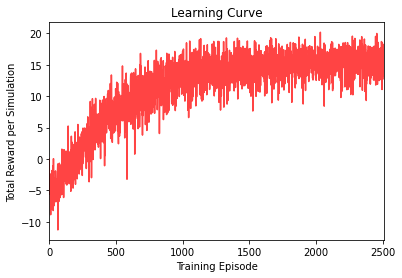

In [10]:
# Plot learning curve
plt.rcParams["figure.figsize"] = (10, 5)
plt.plot(env.total_reward, color="#FF4444")
plt.title("Learning Curve")
plt.xlim(0, len(env.total_reward))
plt.ylabel("Total Reward per Simulation")
plt.xlabel("Training Episode")
plt.show()

if create_logfile:
    json_dict["rl_model_training"]["training_rewards"] = env.total_reward

# Print used data if True
if False:
    print("Total Rewards:", env.total_reward)

### 4. Run simulation

In [11]:
# Convert actions for graphs
def convert_to_marker_pos(action):
    return_list = []
    i = 0
    for entry in action:
        if entry != 0:
            return_list.append(i)
        i += 1
    return return_list


# Graph data
cw_inventory_level, cw_actions = [], []
inventory_levels, actions = {}, {}
manufacturer_inventory = []

for rw_id in env.simulation.get_regional_warehouses():
    inventory_levels[rw_id] = []
    actions[rw_id] = []

In [12]:
# Reset environment for simulation
state = env.reset()
done = False

# Run simulation with model
while not done:
    action, _states = trained_model.predict(state) 
    state, reward, done, info = env.step(action)
    
    # For Graph
    i = 1
    for inv in info["RW Invs:"]:
        inventory_levels[i].append(inv)
        i += 1

    i = 1
    for act in info["Action:"][0:len(env.simulation.get_regional_warehouses())]:
        actions[i].append(act)
        i += 1
    
    try:
        cw_inventory_level.append(info["CW Inv:"])
        cw_actions.append(info["Action:"][-1])
        manufacturer_inventory.append(info["Manufacturer:"])
    except:
        pass
    
    # print(env.simulation.print_state())
    for i in info:
        print(i, info[i], end=" | ")
    print()
    
print("\n", env.evaluation_parameters())

Round: 1 | RW Invs: [62, 57] | Shipments [0, 0] | Action: [0, 0, 0] | Reward: 0.17 | CW Inv: 133 | Manufacturer: 40 | 
Round: 2 | RW Invs: [56, 49] | Shipments [0, 0] | Action: [0, 0, 0] | Reward: 0.19 | CW Inv: 133 | Manufacturer: 60 | 
Round: 3 | RW Invs: [51, 43] | Shipments [0, 1] | Action: [0, 1, 0] | Reward: 0.06 | CW Inv: 103 | Manufacturer: 80 | 
Round: 4 | RW Invs: [44, 37] | Shipments [0, 1] | Action: [0, 0, 0] | Reward: 0.23 | CW Inv: 103 | Manufacturer: 100 | 
Round: 5 | RW Invs: [40, 29] | Shipments [0, 1] | Action: [0, 0, 0] | Reward: 0.25 | CW Inv: 103 | Manufacturer: 100 | 
Round: 6 | RW Invs: [37, 19] | Shipments [0, 1] | Action: [0, 0, 0] | Reward: 0.3 | CW Inv: 103 | Manufacturer: 100 | 
Round: 7 | RW Invs: [30, 12] | Shipments [0, 1] | Action: [0, 0, 0] | Reward: 0.35 | CW Inv: 103 | Manufacturer: 100 | 
Round: 8 | RW Invs: [26, 36] | Shipments [0, 0] | Action: [0, 0, 0] | Reward: 0.27 | CW Inv: 103 | Manufacturer: 100 | 
Round: 9 | RW Invs: [22, 27] | Shipments [0,

###### Inventory level graphs

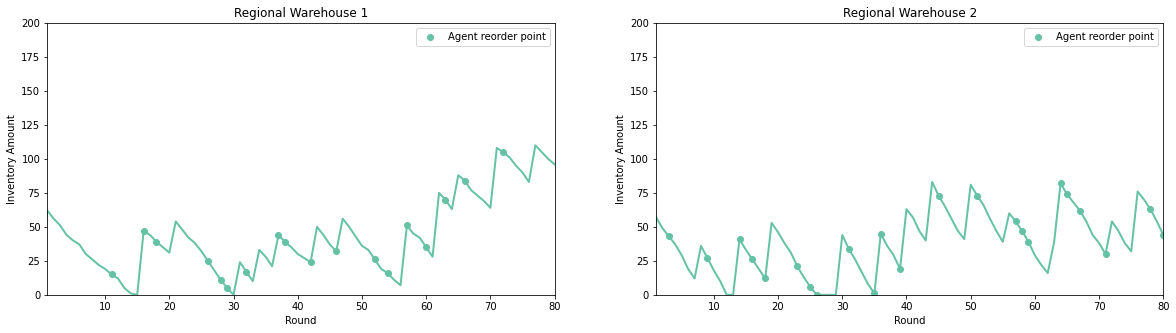

In [13]:
# Plots inventories of regional warehouses

reorder_marker = mlines.Line2D([],[], color='#66C2A5', marker='o', linestyle='None', label="Agent reorder point")
plt.rcParams["figure.figsize"] = (20, 5)

for rw_id in inventory_levels:
    plt.subplot(1, number_of_regional_warehouses, rw_id)
    plt.plot([0] + inventory_levels[rw_id], "-bo", markevery=convert_to_marker_pos([0] + actions[rw_id]), color="#66C2A5", linewidth=2)
    plt.legend(handles=[reorder_marker])
    plt.title("Regional Warehouse " + str(rw_id))
    plt.ylim(0, max_inventory_amount_regional_warehouses)
    plt.xlim(1, simulation_length)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Round")
    
    # Print used data if True
    if False:
        print("RW", rw_id, "data:")
        print("Inventory:", inventory_levels[rw_id])
        print("Actions:", actions[rw_id])
        print("_"*100)

plt.show()

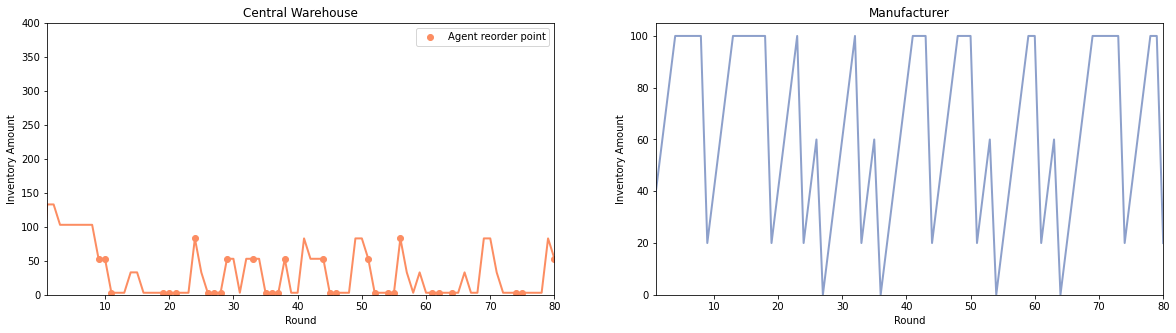

In [14]:
# Plots for CW and Manufacturer (Will only display if manufacturer is simulated)
if len(cw_inventory_level) != 0:
    # Plot for CW inventory with ordering points
    plt.rcParams["figure.figsize"] = (20, 5)
    plt.subplot(1, 2, 1)
    reorder_marker = mlines.Line2D([],[], color='#FC8D62', marker='o', linestyle='None', label="Agent reorder point")
    plt.plot([0] + cw_inventory_level, "-bo", color="#FC8D62", markevery=convert_to_marker_pos([0] + cw_actions), linewidth=2)
    plt.legend(handles=[reorder_marker])
    plt.title("Central Warehouse")
    plt.ylim(0, max_inventory_amount_central_warehouse)
    plt.xlim(1, simulation_length)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Round")
    
    # Plot for manufacturer inventory
    plt.subplot(1, 2, 2)
    plt.plot([0] + manufacturer_inventory, color="#8DA0CB", linewidth=2)
    plt.title("Manufacturer")
    plt.ylim(0, env.simulation.get_manufacturer().get_inventory_limit()+5)
    plt.xlim(1, simulation_length)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Round")
    plt.show()
    
    # Print used data if True
    if False:
        print("CW Inventory:", cw_inventory_level)
        print("CW Actions:", cw_actions)
        print("Manufacturer Inventrory:", manufacturer_inventory)

### 5. Create Logfile

In [15]:
if create_logfile:
    simulation_run_data = {}
    simulation_run_data["stats"] = env.evaluation_parameters()
    for rw_id in inventory_levels:
        simulation_run_data["regional_warehouse_" + str(rw_id)] = {}
        simulation_run_data["regional_warehouse_" + str(rw_id)]["inventory"] = inventory_levels[rw_id]
        simulation_run_data["regional_warehouse_" + str(rw_id)]["actions"] = actions[rw_id]
    
    if len(cw_inventory_level) != 0:
        simulation_run_data["central_warehouse"] = {}
        simulation_run_data["central_warehouse"]["inventory"] = str(cw_inventory_level) # Fix intc not compatiple with json (str for temp fix)
        simulation_run_data["central_warehouse"]["actions"] = str(cw_actions)
        
        simulation_run_data["manufacturer"] = {}
        simulation_run_data["manufacturer"]["inventory"] = manufacturer_inventory

    json_dict["simulation_run_data"] = simulation_run_data
    
    now = datetime.now()
    dt_string = now.strftime("%Y-%m-%d_%H-%M-%S")
    
    with open(logfile_location + "/logfile_" + dt_string + ".json", 'w') as f:
        options = jsbeautifier.default_options()
        options.indent_size = 4
        f.write(jsbeautifier.beautify(json.dumps(json_dict), options))
        print("Logfile was created")

Logfile was created
